In [86]:
from header import *

In [87]:
dataset = ds.dataset(list(Path(f"new_sig/").glob("*.parquet")), format="parquet")

In [88]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'cmpmiss', 'cmthetamiss', 'fox_ups',
       'asymmetry', 'pBtag', 'theta_Btag', 'MBtag', 'rec_theta_Btag', 'idec0',
       'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik', 'N_KS',
       'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'p_tau_0_tagcm',
       'p_tau_1_tagcm', 'ang_taus', 'ang_taus_tagcm', 'ang_tau0_pmiss',
       'ang_tau1_pmiss', 'ang_tau1_ROE', 'ang_tau0_ROE', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'totalEnergyMC', 'E_gamma_in_ROE',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')


In [89]:
mods_cut = {'lep': [mask_lep, 'lep', 'e / \\mu', 0.1, 0.015],
        'pipi': [mask_pi, 'pirho', '\\pi \\pi', 0.1, 0.015],
        'rhorho': [mask_rho, 'pirho', '\\rho \\rho', 0.1, 0.015],
        'pirho': [mask_pirho, 'pirho', '\\pi \\rho', 0.1, 0.015],
        'pilep': [mask_pilep, 'pirho_lep', '\\pi \\ell', 0.1, 0.015],
        'rholep': [mask_rholep, 'pirho_lep', '\\rho \\ell', 0.1, 0.015],}

In [90]:
current_mod = 'rholep'

In [91]:
import json
with open(f"models/columns_and_fom_{mods_cut[current_mod][1]}.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [92]:
data = get_values(dataset, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask_sig & mods_cut[current_mod][0]))

Total data size: 0.58 MB


In [93]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model(f"models/bdt_model_{mods_cut[current_mod][1]}.json")
with open(f"models/columns_and_fom_{mods_cut[current_mod][1]}.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"][current_mod]

In [94]:
X_new = data[columns]

bdt_scores = model.predict_proba(X_new)[:, 1] 

data["bdt_score"] = bdt_scores

selected_mask = data["bdt_score"] > FoM

selected_data = data[selected_mask]

In [95]:
wbin = 0.05
a = 0 
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

In [96]:
BS0 = 5.366691

In [97]:
wbin_x, a_x, b_x = mods_cut[current_mod][3], 0, 1.2
wbin_y, a_y, b_y = mods_cut[current_mod][4], Bs_m - 0.15, Bs_m + 0.15 

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x + 2))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y + 2))

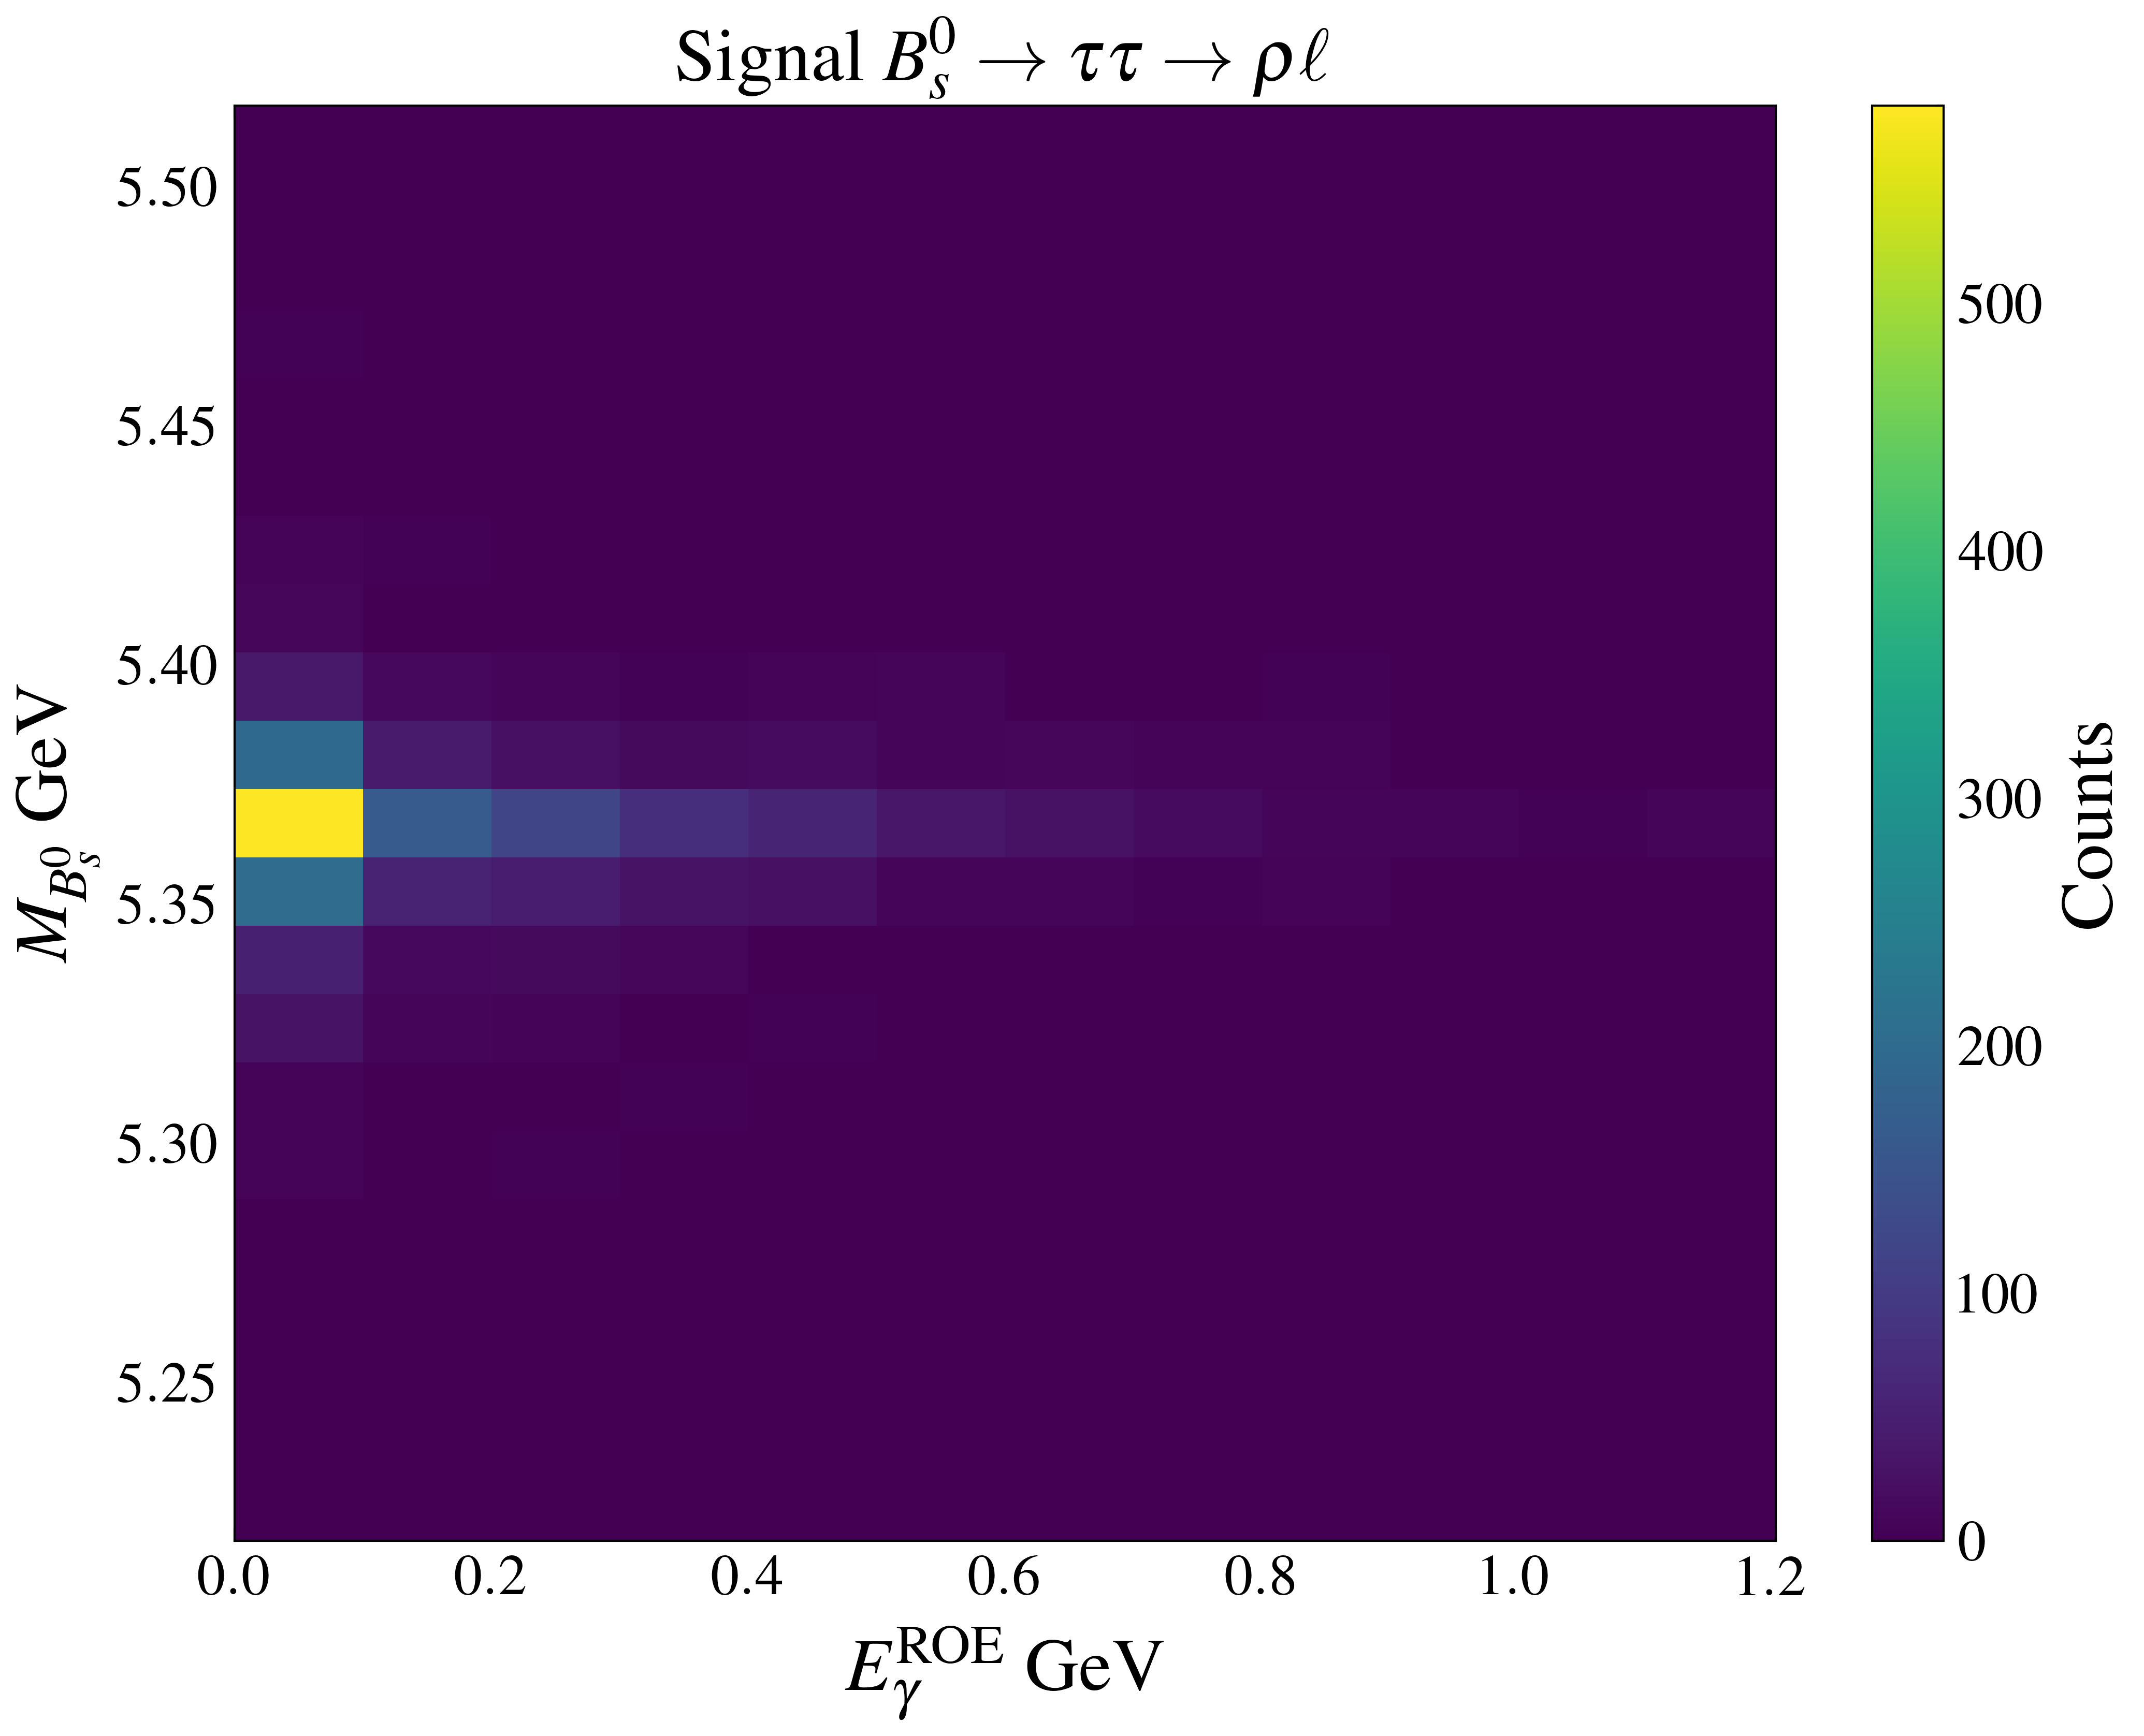

In [98]:
values = selected_data[["E_gamma_in_ROE", "MBtag"]].values

counts, _ = np.histogramdd(values, bins=(bins_x, bins_y))
bin_centers = [0.5 * (b[:-1] + b[1:]) for b in (bins_x, bins_y)]
bin_centers = np.meshgrid(*bin_centers, indexing='ij')



plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}\ \mathrm{GeV}$")
plt.ylabel(r"$M_{B_s^0}\ \mathrm{GeV}$")
plt.title(rf"Signal $B_s^0 \to \tau \tau \to {mods_cut[current_mod][2]}$")
plt.colorbar(pmesh, label="Counts")
plt.savefig(f"output/sig_E_ROE_M_Bs{current_mod}.pdf", dpi=700)
plt.show()

In [99]:
hist = hist_approx()
hist.put_hist(bin_centers, counts)
hist.save_hist(f"shapes/sig_{current_mod}.json")
json_update(f"quantity/N_{current_mod}.json", {"N_sig": selected_data.shape[0]})

Файл 'quantity/N_rholep.json' обновлён или создан заново.
